NOTES:
The main issue here is that we don't know what test to do to compute the differece between a state's ranking vs how the other states rank. (Mann whitney U?)
The last graph looks "promising" but why all values are significant for all states makes no sense. (red vs blue)
Should we look simply whether there is a is statistical difference in average rating for the states? (not just whether it is higher than how other people score it)

Q1: Do Californians prefer Californian beer over non Californians? (Its for all US states but just for question focus purposes)
This question is for BeerAdvocate data which we established before has a lot of data on US states.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [ ]:
#rankings data with beer_location and user_location added as extra columns
US_ratings = pd.read_csv('../../../USData/BA_US_states_all.csv')

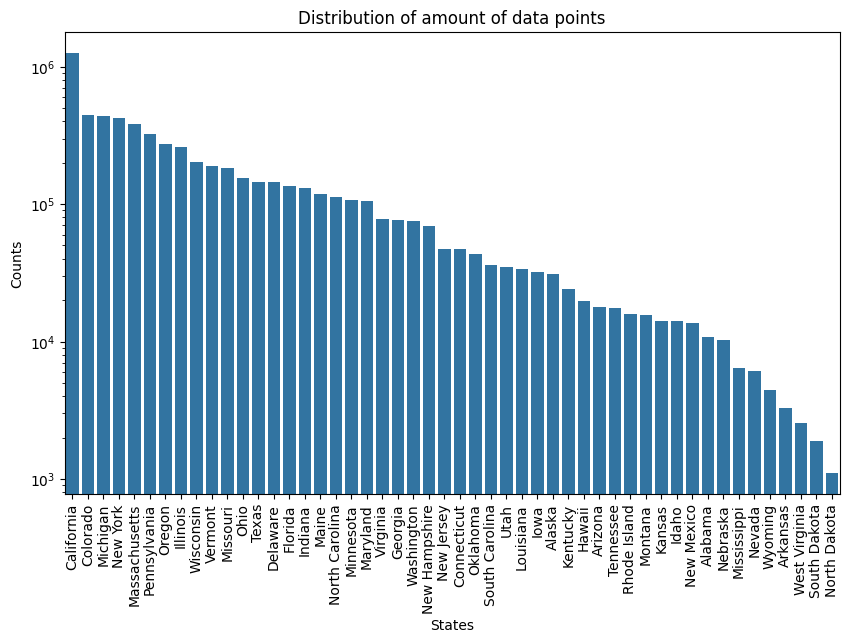

In [89]:
counts = US_ratings.groupby(['beer_state'])['avg'].count()
counts = counts.sort_values(ascending=False)
#histogram of the average ratings
plt.figure(figsize=(10, 6))
sns.barplot(counts)
plt.title("Distribution of amount of data points")
plt.xlabel("States")
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel("Counts")
plt.show()


In [ ]:
#Average rating of all users by state for all states
#Mean calculated by grouping rankings by user_state and beer_state

state_ratings = US_ratings.groupby(['user_state', 'beer_state'])['avg'].mean().reset_index()
state_ratings.head(2)

,user_state,beer_state,avg
0,Alabama,Alabama,3.842899
1,Alabama,Alaska,3.852717


In [61]:
#create matrix which gives the avg rating of each beers of state to user of state combination pair
#ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg')
state_ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg', fill_value=0)
state_ratings_matrix.head(2)

beer_state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
user_state,,,,,,,,,,,,,,,,,,,,,
Alabama,3.842899,3.852717,3.240513,3.717222,3.991335,3.772443,4.045263,3.949393,3.831054,3.831031,...,3.746667,3.765035,3.655649,3.656977,3.801226,3.690347,3.681420,3.747143,3.390454,3.908
Alaska,3.809091,3.908503,3.763333,3.480000,4.029584,3.872363,4.036000,3.965247,3.948252,3.872750,...,3.587500,3.740000,3.842672,3.915357,4.098214,3.800000,3.825049,3.430000,3.534313,4.104


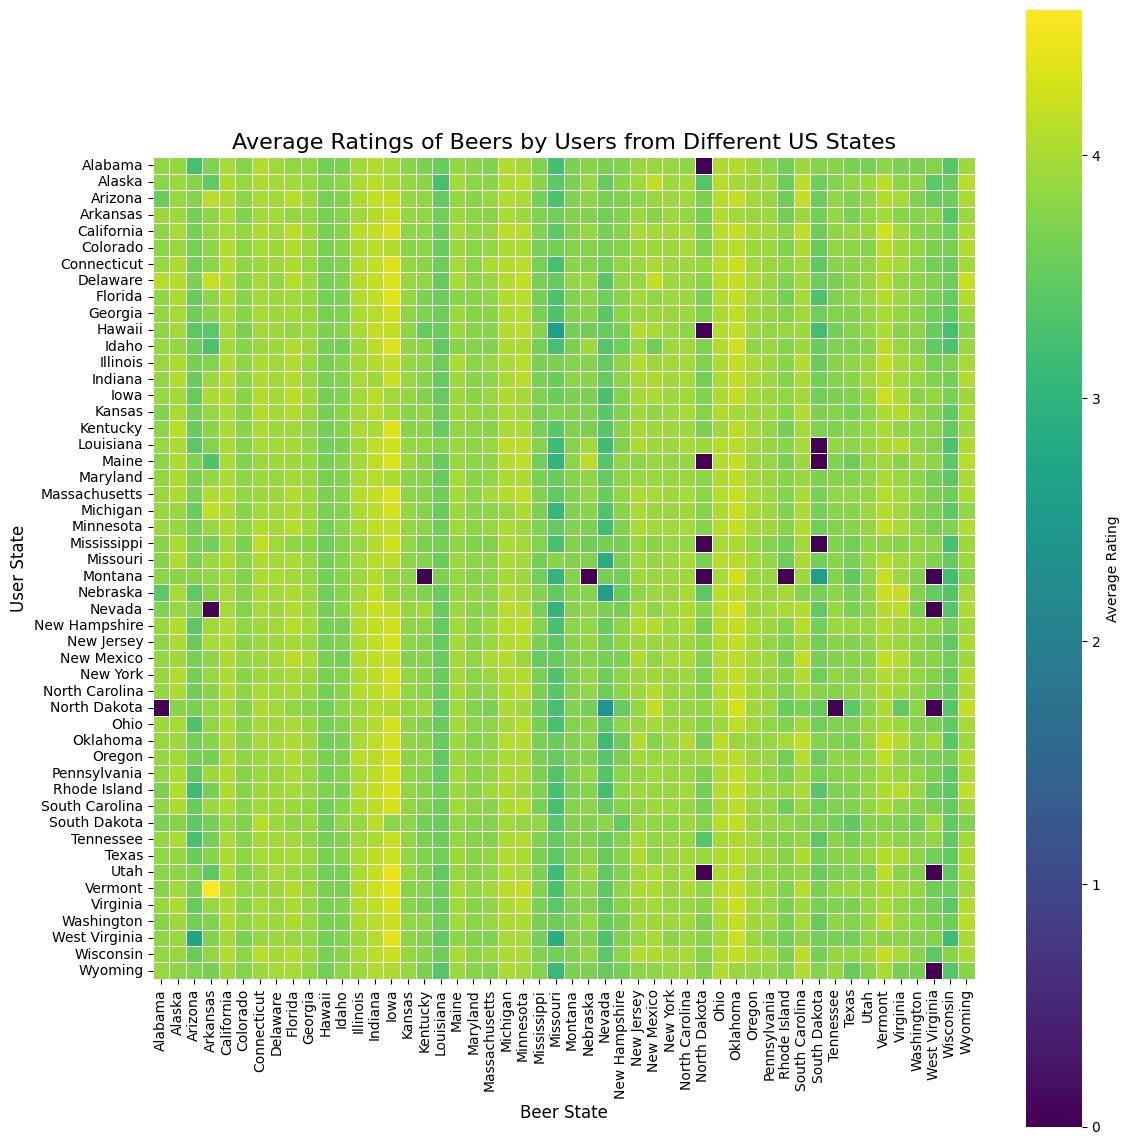

In [63]:
plt.figure(figsize=(12, 12))

sns.heatmap(state_ratings_matrix, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Average Rating'}, square=True)

plt.title('Average Ratings of Beers by Users from Different US States', fontsize=16)
plt.xlabel('Beer State', fontsize=12)
plt.ylabel('User State', fontsize=12)
plt.tight_layout()

plt.show()


There are several problems here: when there are no ratings we need to put Nan not 0.

Below we are comparing the difference between the average ratings for the beers in the state compared to the average rating given by all other 49 states.

C:\Users\Enzo\AppData\Local\Temp\ipykernel_26088\1064256621.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(


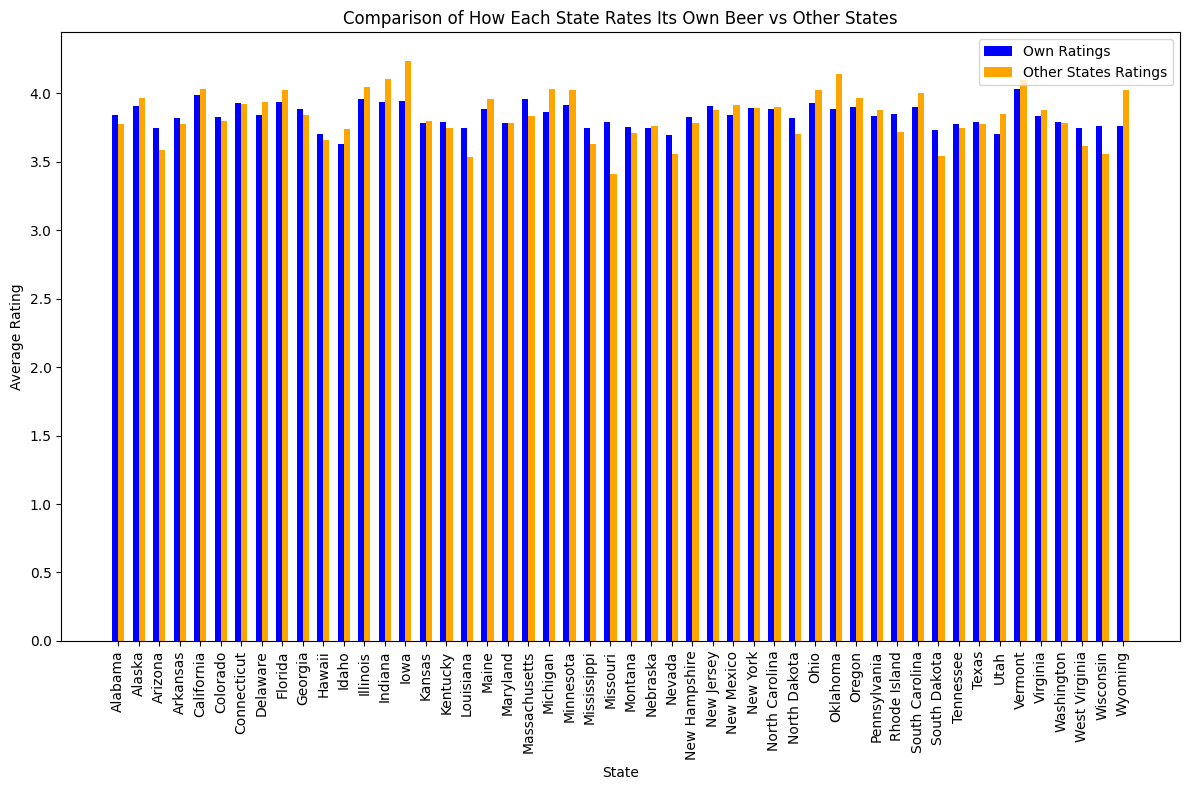

In [53]:
#average ratings for each state when rating its own beer
own_beer_ratings = US_ratings[US_ratings['user_state'] == US_ratings['beer_state']].groupby('beer_state')['avg'].mean()

#total number of ratings per beer_state
total_ratings_per_state = US_ratings.groupby('beer_state').size()

#weighted average rating for each beer by other states
other_state_ratings = US_ratings[US_ratings['user_state'] != US_ratings['beer_state']]
other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(
    lambda group: np.average(group['rating'], weights=group['user_state'].map(total_ratings_per_state))
)

ratings_comparison = pd.DataFrame({
    'own_beer_avg': own_beer_ratings,
    'other_states_avg': other_state_avg_ratings
})

ratings_comparison['other_states_avg'] = ratings_comparison['other_states_avg'].fillna(0)
plt.figure(figsize=(12, 8))

bar_width = 0.3
index = np.arange(len(ratings_comparison)) 

#allows us to place the bars next to each other
plt.bar(index - bar_width / 2, ratings_comparison['own_beer_avg'], bar_width, label='Own Ratings', color='blue')
plt.bar(index + bar_width / 2, ratings_comparison['other_states_avg'], bar_width, label='Other States Ratings', color='orange')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of How Each State Rates Its Own Beer vs Other States')
plt.xticks(index, ratings_comparison.index, rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


C:\Users\Enzo\AppData\Local\Temp\ipykernel_26088\897117608.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]],


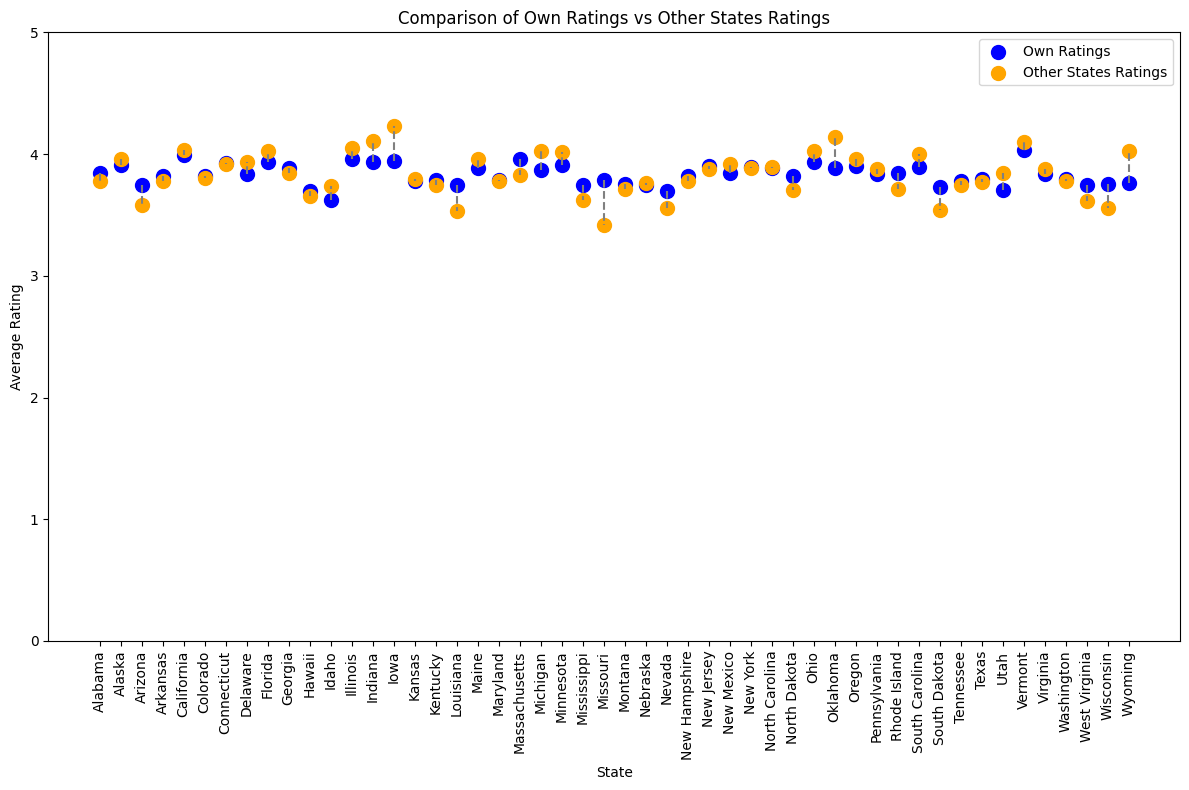

In [54]:
plt.figure(figsize=(12, 8))

#dots for better visibility
plt.scatter(ratings_comparison.index, ratings_comparison['own_beer_avg'], label='Own Ratings', color='blue', s=100, zorder=2)
plt.scatter(ratings_comparison.index, ratings_comparison['other_states_avg'], label='Other States Ratings', color='orange', s=100, zorder=2)

#lines connecting the dots for visibility
for i in range(len(ratings_comparison)):
    plt.plot([ratings_comparison.index[i], ratings_comparison.index[i]], 
             [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]], 
             color='gray', linestyle='--')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of Own Ratings vs Other States Ratings')
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()

plt.show()


Added global average of the state beers added
We need to perform statistical tests in order to verify if there is a statistical difference in the way people from a state rank their own beers compared to how other states rank said state. We could take each state independently

Questions we need to answer:

Do Texans[replace state with any state] rate their own beer higher than other US states rate Texan beer?
Do Texans[replace state with any state] rate their own beer higher than the global rating of Texan beer?


WHAT TYPE OF TEST DE WE DO to quantify the difference in average rating?
Things to consider when selecting the stat test: normality? Independence of groups? High volume of data? Large difference in number of data points for local ratings vs all other ratings?

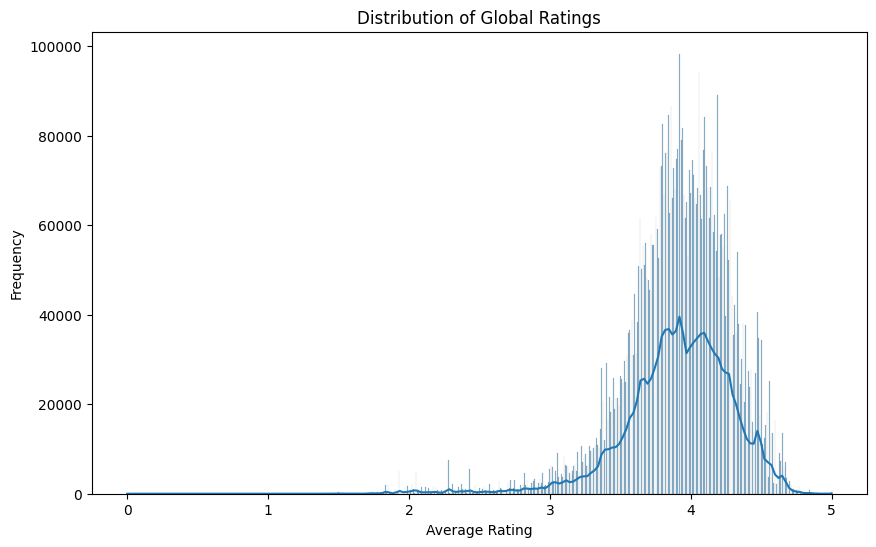

In [56]:
#Point of this is to check if the data is normally distributed

#histogram of the average ratings
plt.figure(figsize=(10, 6))
sns.histplot(US_ratings['avg'], kde=True)
plt.title("Distribution of Global Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

In [57]:
#Test allows us to statistically verify if the data is normally distributed
ks_test = stats.kstest(US_ratings['avg'], 'norm', args=(US_ratings['avg'].mean(), US_ratings['avg'].std()))
print("Kolmogorov-Smirnov Test:")
print(f"Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")


Kolmogorov-Smirnov Test:
Statistic=0.06600630121805295, p-value=0.0


OK we can definitively say that this data is not normally distributed!!! p value = 0.0 :(
Below I have proposed a Mann-Whitney U test but I this would work better with small datasets

In [58]:
#Play around with this and check whether or not there is a difference between X state and all other states

local_texas_ratings = US_ratings[(US_ratings['user_state'] == 'Texas') & (US_ratings['beer_state'] == 'Texas')]['rating']
nonlocal_texas_ratings = US_ratings[(US_ratings['user_state'] != 'Texas') & (US_ratings['beer_state'] == 'Texas')]['rating']

stat, p_value = mannwhitneyu(local_texas_ratings, nonlocal_texas_ratings, alternative='greater')

print(f'Mann-Whitney U Statistic: {stat}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print("There is a statistically significant difference, and Texan ratings are higher than other US states' ratings.")
else:
    print("There is no statistically significant difference between Texan ratings and other US states' ratings.")


Mann-Whitney U Statistic: 2740503828.5
p-value: 1.816779648233991e-98
There is a statistically significant difference, and Texan ratings are higher than other US states' ratings.


             state  state_avg  other_states_avg        p_value  \
4         Missouri   3.823841          3.425019   0.000000e+00   
31       Louisiana   3.791667          3.540684  5.045716e-189   
1        Wisconsin   3.793467          3.550564   0.000000e+00   
29          Nevada   3.751859          3.520708   4.242437e-24   
36   West Virginia   3.841070          3.623372   2.775359e-25   
8          Arizona   3.789245          3.577505   9.146263e-96   
42        Arkansas   3.955613          3.752037   3.571575e-22   
32    South Dakota   3.764837          3.566424   4.742261e-20   
40    Rhode Island   3.891898          3.710939   8.776180e-74   
35     Mississippi   3.801965          3.643772   1.455969e-23   
47         Montana   3.852338          3.718161   1.327150e-28   
44         Alabama   3.919936          3.786342   8.926670e-42   
21   Massachusetts   3.966313          3.837522   0.000000e+00   
46    North Dakota   3.841897          3.714255   3.409497e-05   
13        

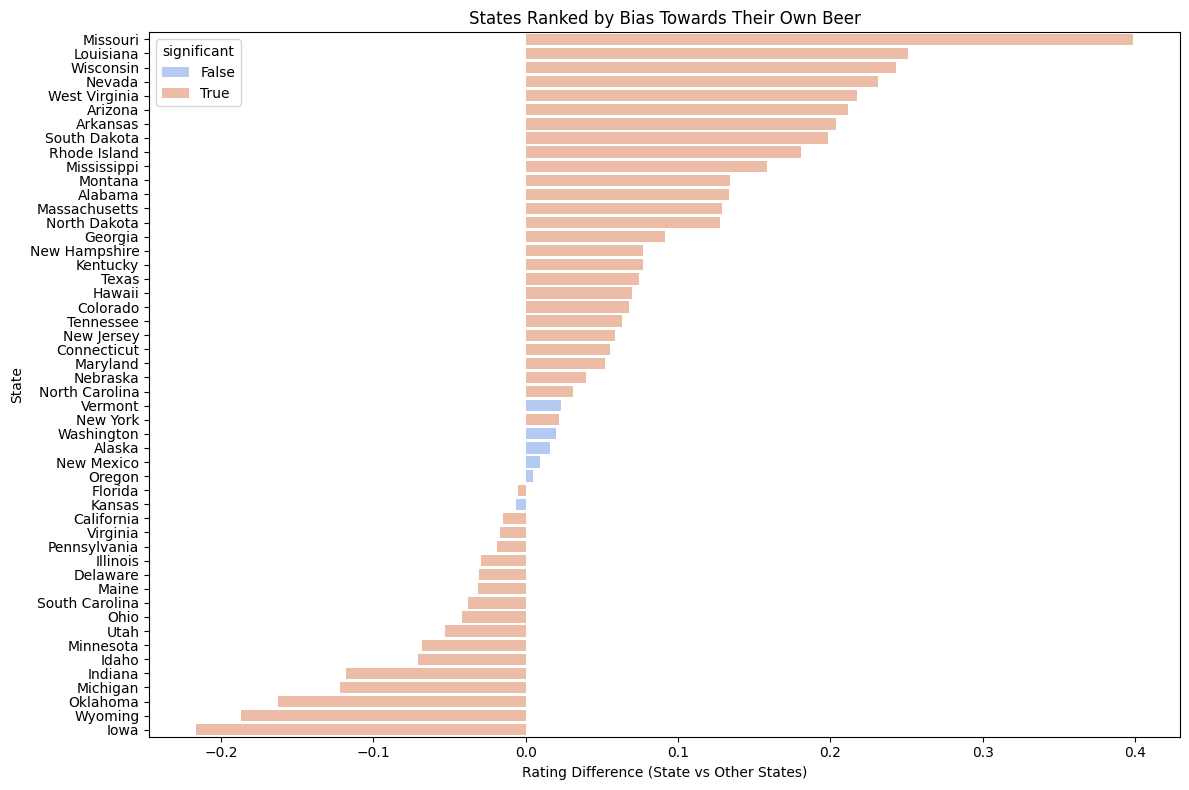

In [59]:
#calculate Mann-Whitney U and average ratings for each state
def calculate_bias(state, US_ratings):

    state_ratings = US_ratings[(US_ratings['user_state'] == state) & (US_ratings['beer_state'] == state)]['rating']
    other_states_ratings = US_ratings[(US_ratings['user_state'] != state) & (US_ratings['beer_state'] == state)]['rating']
    
    state_avg = state_ratings.mean()
    other_states_avg = other_states_ratings.mean()
    
    stat, p_value = mannwhitneyu(state_ratings, other_states_ratings, alternative='two-sided')
    
    return state_avg, other_states_avg, p_value


states = US_ratings['user_state'].unique()

bias_results = []

for state in states:
    state_avg, other_states_avg, p_value = calculate_bias(state, US_ratings)
    bias_results.append({
        'state': state,
        'state_avg': state_avg,
        'other_states_avg': other_states_avg,
        'p_value': p_value,
        'rating_difference': state_avg - other_states_avg
    })


bias_df = pd.DataFrame(bias_results)

bias_df['significant'] = bias_df['p_value'] < 0.05


bias_df = bias_df.sort_values(by=['rating_difference', 'significant'], ascending=False)
print(bias_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='rating_difference', y='state', data=bias_df, palette='coolwarm', hue='significant')

plt.xlabel('Rating Difference (State vs Other States)')
plt.ylabel('State')
plt.title('States Ranked by Bias Towards Their Own Beer')
plt.tight_layout()

plt.show()

In the graph the the negative scores is where the state is ranking their beer HIGHER than the US average